# Figure One: Alignment (in Carrington Longitude)

- Panel One: PSP Cross Helicity ($\rm |\sigma_C|$)
- Panel Two: PSP & Solar Orbiter Velocity ($\rm v_R [km/s]$)
- Panel Three: PSP & Solar Orbiter Scaled Radial Magnetic Field ($\rm B_R \; R^2 [nT]$) 
- Panel Four: PSP & Solar Orbiter Source Surface Position (lon, lat) as function of velocity

## Imports

In [1]:
import os

import datetime
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

import astrospice
import sunpy.coordinates as scoords
from astropy.coordinates import SkyCoord

import tools.sigma as sigma
import tools.utilities as utils
from tools.psp_funcs import ballistically_project
for sc in ['psp','solar orbiter'] : kernels = astrospice.registry.get_kernels(sc,'predict') 

# COLORS
c = ['#ae017e','#085A99',  '#c98000'] # darker colors
lightc = ['#FCA4C4',  '#8FD3F4', '#FFCC70'] # lighter colors
fcol = 'mistyrose'
sacol='lavender'
sacol = 'violet'
scol = 'lightgreen'
hcol = 'lightblue'
aa = 0.6
lw=2
clon = '#ae017e'
clat = '#085A99'
rcol = 'dimgrey'
cmaps = ['RdPu', 'cool', 'Wistia', 'spring']

# REGIONS
loc_hcs = [113, 116]
ssw = [166, 175]
sasw = [175, 185]
fsw = [70, 85]

# DIRECTORIES
IMG_DIR = './figures'
DF_DIR = './results'
PlotDir = '/Users/tamarervin/mplstyle/'

STORAGE_DIR = '/Volumes/TAMARUSB/pub_data/e11_ch'
RES_DIR = os.path.join(STORAGE_DIR, 'results')

# PLOT STYLING
plot_style = os.path.join(PlotDir, 'figure_series.mplstyle')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'
plt.rcParams.update({'font.size': 18})
plt.style.use(plot_style)

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

08-Jan-24 10:55:22: /Users/tamarervin/miniconda3/envs/analysis/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),



Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

## Data

In [2]:
# ### READ IN DATA ###
parker, parkerdownt, parkerdownl, pss, orbiter, orbiterdownl, orbiterdownt, oss, his_orbiter, his_orbiterdownt, his_orbiterdownl = utils.read_data(RES_DIR, sigma_time=20)

### DEFINE REGIONS ###
lon_footpoints = parker.sslon
hhcs = np.logical_and(lon_footpoints >= loc_hcs[0], lon_footpoints <=loc_hcs[1])
slow = np.logical_and(lon_footpoints >=sasw[0], lon_footpoints <=sasw[1])
fast = np.logical_and(lon_footpoints >=fsw[0], lon_footpoints <=fsw[1])


08-Jan-24 10:55:46: /Users/tamarervin/publications/e11_ch/tools/utilities.py:180: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  pss = parker.resample(sigma_bin, closed='left', label='left', loffset=sigma_bin / 2).mean()

08-Jan-24 10:55:46: /Users/tamarervin/publications/e11_ch/tools/utilities.py:180: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pss = parker.resample(sigma_bin, closed='left', label='left', loffset=sigma_bin / 2).mean()

08-Jan-24 10:55:49: /Users/tamarervin/publications/e11_ch/tools/utilities.py:189: FutureWarning: 'loffset' in .resample() and in Group

In [4]:
use = np.logical_and(orbiter.sslon>50, orbiter.sslon<205)
orbiter = orbiter[use].copy()

## Generate Position

Functions from https://github.com/STBadman/PSP_E10_Sources/blob/main/helpers.py


In [5]:
dt_start,dt_end = datetime.datetime(2022,2,19),datetime.datetime(2022,3,6)
dt_common = utils.gen_dt_arr(dt_start, dt_end, cadence_days=1/48)
ts_common = np.array([dt.timestamp() for dt in dt_common])

# get carrington locations at these timestamps for each instrument
### Create SkyCoord for PSP in the inertial (J2000) frame
psp_inertial = astrospice.generate_coords(
    'SOLAR PROBE PLUS', dt_common

)
### Transform to solar co-rotating frame 
psp_carrington = psp_inertial.transform_to(
   scoords.HeliographicCarrington(observer="self")
)

### Create SkyCoord for SolO in the inertial (J2000) frame
solo_inertial = astrospice.generate_coords(
    'Solar Orbiter', dt_common

)
### Transform to solar co-rotating frame 
solo_carrington = solo_inertial.transform_to(
    scoords.HeliographicCarrington(observer="self")
)

# get velocity
psp_vr_ts = [int(dt.timestamp()) for dt in parker.Time]
psp_vr_common = interp1d(psp_vr_ts,parker.vr,bounds_error=False)(ts_common)*u.km/u.s
solo_vr_ts = [int(dt.timestamp()) for dt in orbiter.Time]
solo_vr_common = interp1d(solo_vr_ts,orbiter.vr,bounds_error=False)(ts_common)*u.km/u.s

# projection
psp_projected = ballistically_project(psp_carrington,vr_arr=psp_vr_common)
solo_projected = ballistically_project(solo_carrington,vr_arr=solo_vr_common)

In [6]:
orbiter = orbiter.set_index(orbiter.Time)
bin_size = pd.Timedelta(minutes=20) # 3 hour cadence
dd = orbiter.resample(bin_size, closed='left').mean()

08-Jan-24 10:58:44: /var/folders/by/lx780c7j7w58m_tkpc3q83kc0000gn/T/ipykernel_4874/2496630428.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dd = orbiter.resample(bin_size, closed='left').mean()



## Create Plot

08-Jan-24 11:00:00: The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


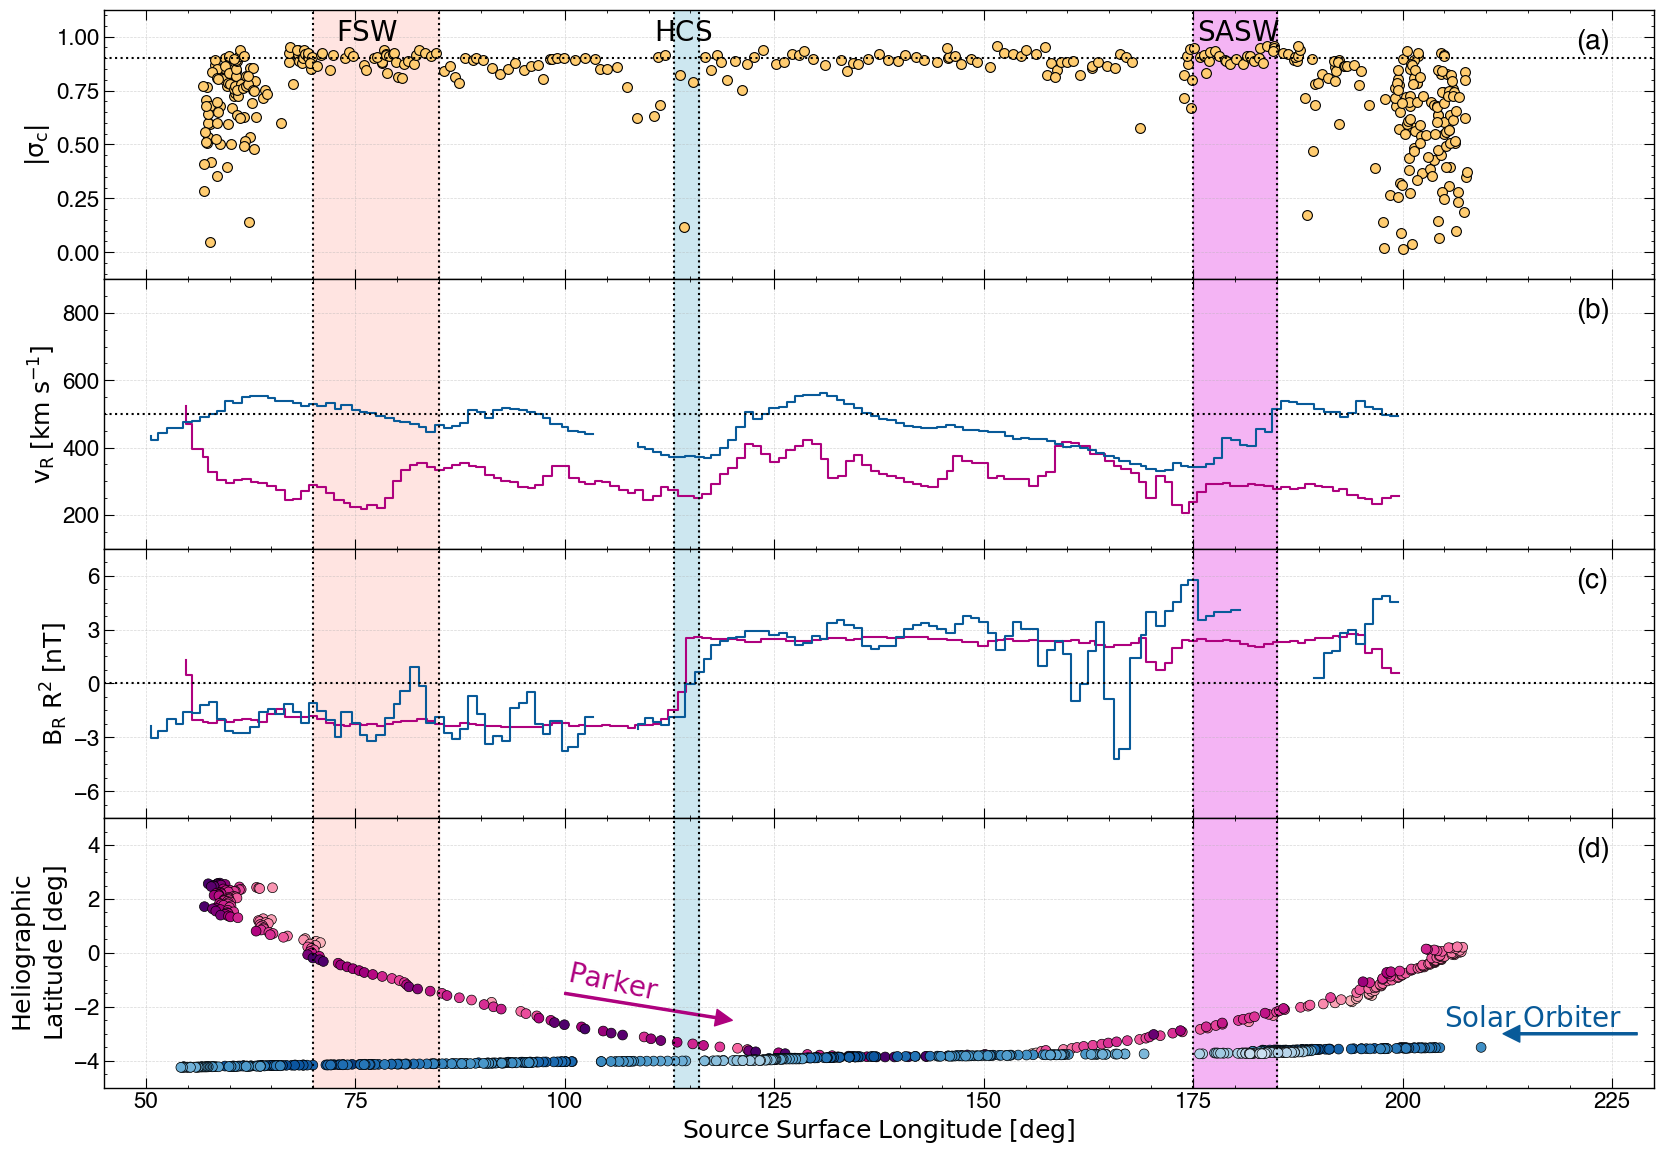

In [9]:
### FIGURE SETUP
ss=20
si=10
fig, axes = plt.subplots(4, 1, figsize=[20, 14], sharex='all', gridspec_kw={'hspace': 0})

##### ---------- PANEL ONE: PSP CROSS HELICITY  ---------- ######
axes[0].scatter(pss.sslon,
                np.abs(pss.sigmac), # c=pss.vr,           
                c=lightc[2], s=50, 
                edgecolor='k', linewidth=0.8
)

axes[0].axhline(0.9, color='k', linestyle='dotted')

#### ---------- PANEL TWO: VELOCITY ----------- #######
### RAW DATA
# axes[1].scatter(parker.sslon[::si],
#                 parker.vr[::si],          
#                 c=lightc[0], s=ss,
#                 alpha=0.5, linewidth=0.5, edgecolor='k'
# )             
# axes[1].scatter(orbiter.sslon[::si],
#                 orbiter.vr[::si],               
#                 c=lightc[1], s=ss,
#                 alpha=0.5, linewidth=0.5, edgecolor='k'
# )

### BINNED DATA
axes[1].step(parkerdownl.sslon,
                  parkerdownl.vr,          
                  c=c[0]
)
axes[1].step(orbiterdownl.sslon,
                     orbiterdownl.vr,          
                     c=c[1]
)

### THRESHOLD
axes[1].axhline(500, color='k', linestyle='dotted')

##### ---------- PANEL THREE: RADIAL MAGNETIC FIELD  ---------- ######
### RAW DATA
# axes[2].scatter(parker.sslon[::si],
#                      parker.BrR2[::si],  
#                      c=lightc[0], s=ss,
#                      alpha=0.5, linewidth=0.5, edgecolor='k'   
# )
# axes[2].scatter(orbiter.sslon[::si],
#                       orbiter.BrR2[::si],               
#                       c=lightc[1], s=ss,
#                       alpha=0.5, linewidth=0.5, edgecolor='k'
# )

### BINNED DATA
axes[2].step(parkerdownl.sslon,
                     parkerdownl.BrR2,          
                     c=c[0]
                    )
axes[2].step(orbiterdownl.sslon,
                     orbiterdownl.BrR2,          
                     c=c[1]
                    )
### THRESHOLD
axes[2].axhline(0, color='k', linestyle='dotted')

##### ---------- PANEL FOUR: POSITION AS FUNC OF VELOCITY  ---------- ######

# Normalize SolO and PSP data separately due to acceleration
normsolo=plt.Normalize(200,600) 
normpsp=plt.Normalize(100,400)

# plot full trajectory
cpsp=axes[3].scatter(psp_projected.lon,
                     psp_projected.lat,               
                     c=psp_vr_common.value,
                     norm = normpsp,
                     cmap='RdPu',
                     edgecolor='k', linewidth=0.5, s=50
                  )
csolo=axes[3].scatter(solo_projected.lon,
                      solo_projected.lat,               
                      c=solo_vr_common.value,
                      norm = normsolo,
                      cmap='Blues',
                      edgecolor='k', linewidth=0.5, s=50
                    )

###### SC MOTION #######
axes[3].text(100, -1.75, r"$\rm Parker$",fontsize=20,weight="bold",rotation=-12, c=c[0])
axes[3].annotate(None,(120,-2.5),(100,-1.5),arrowprops=dict(color=c[0], width=1.5))
axes[3].text(205, -2.75, r"$\rm Solar \; Orbiter$",fontsize=20, weight="bold", c=c[1])
axes[3].annotate(None,(212,-3),(228,-3),arrowprops=dict(color=c[1], width=1.5))


###### LABELS & RANGES #######
ylabels = [r'$\rm |\sigma_c|$', r'$\rm v_R \; [km \; s^{-1}]$', r'$\rm B_R \; R^2 \;  [nT]$', r'$\rm Heliographic$' + '\n' r'$\rm Latitude \; [deg]$']
panel_labels=['(a)', '(b)', '(c)', '(d)']
for i, ax in enumerate(axes):
    ax.tick_params(axis='both', which='major', labelsize=16) 
    ax.set(xlim=(45, 230), xticks=np.arange(50, 226, step=25))
    ax.set_ylabel(ylabel=ylabels[i], fontsize=18)
    # add grid
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    # plot hcs 
    ax.axvline(loc_hcs[0], color='k', linestyle='dotted', zorder=5)
    ax.axvline(loc_hcs[1], color='k', linestyle='dotted', zorder=5)
    # ax.axvline(ssw[0], color='k', linestyle='dotted', zorder=5)
    # ax.axvline(ssw[1], color='k', linestyle='dotted', zorder=5)
    ax.axvline(fsw[0], color='k', linestyle='dotted', zorder=5)
    ax.axvline(fsw[1], color='k', linestyle='dotted', zorder=5)
    ax.axvline(sasw[0], color='k', linestyle='dotted', zorder=5)
    ax.axvline(sasw[1], color='k', linestyle='dotted', zorder=5)

    # shade interesting regions
    ax.axvspan(fsw[0], fsw[1], alpha=1, color=fcol, zorder=-3)
    ax.axvspan(sasw[0], sasw[1], alpha=.6, color=sacol, zorder=-3)
    ax.axvspan(loc_hcs[0], loc_hcs[1], alpha=.6, color=hcol, zorder=-3)
    # ax.axvspan(ssw[0], ssw[1], alpha=.6, color=scol, zorder=-3)

    # panel labels
    ax.text(0.95, 0.93, panel_labels[i], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.set_xlabel(xlabel=r'$\rm Source \; Surface \; Longitude \; [deg]$', fontsize=18)

###### AXES TICKS #######
axes[0].set(ylim=(-0.125, 1.125), yticks=np.arange(0, 1.1, step=0.25))
axes[1].set(ylim=(100, 900), yticks=np.arange(200, 801, step=200))
axes[2].set(ylim=(-7.5, 7.5), yticks=np.arange(-6, 6.1, step=3))
axes[3].set(ylim=(-5, 5), yticks=np.arange(-4, 4.1, step=2))


###### REGION LABELS #######
ax = axes[0]
ax.text(0.15, 0.96, r'$\rm FSW$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.text(0.355, 0.96, r'$\rm HCS$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
# ax.text(0.655, 0.96, r'$\rm SSW$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.text(0.705, 0.96, r'$\rm SASW$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

###### SAVE FIGURE #######
plt.savefig(os.path.realpath('figures/fig1.png'), bbox_inches='tight') # PNG
plt.savefig(os.path.realpath('eps_figures/fig1.eps'), bbox_inches='tight', transparent=True) # EPS

## Appendix Figure

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


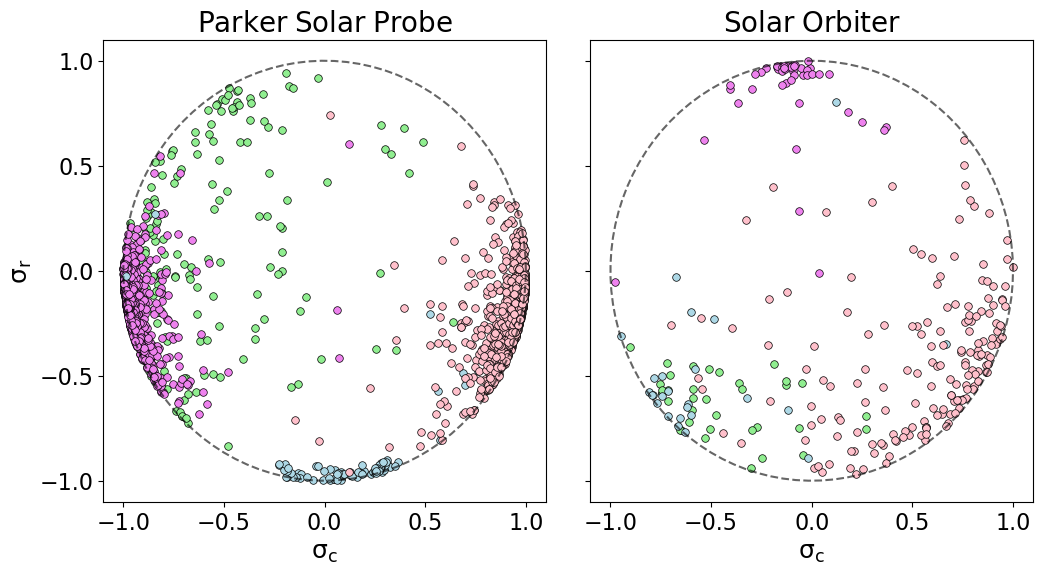

In [12]:
fig, axs = plt.subplots(1, 2, figsize=[12, 6], sharex='all', sharey='all', gridspec_kw={'wspace': 0.1})
ss=30


### --------- PANEL ONE: PARKER --------- ###
### GET FOOTPOINTS ###
pp = parker
lon_footpoints = pp.sslon
fast = np.logical_and(lon_footpoints >= fsw[0], lon_footpoints <=fsw[1])
salf = np.logical_and(lon_footpoints >= sasw[0], lon_footpoints <=sasw[1])
hhcs = np.logical_and(lon_footpoints >= loc_hcs[0], lon_footpoints <=loc_hcs[1])
slow = np.logical_and(lon_footpoints >=ssw[0], lon_footpoints <=ssw[1])

### PLOTTING ###
# cbb = axs[0].scatter(pp.sigmac[slow], pp.sigmar[slow], c='lightgreen', s=ss, edgecolor='k', linewidth=0.5)
cbb = axs[0].scatter(pp.sigmac[salf], pp.sigmar[salf], c='violet', s=ss, edgecolor='k', linewidth=0.5)
cbb = axs[0].scatter(pp.sigmac[hhcs], pp.sigmar[hhcs], c='lightblue', s=ss, edgecolor='k', linewidth=0.5)
cbb = axs[0].scatter(pp.sigmac[fast], pp.sigmar[fast], c='pink', s=ss, edgecolor='k', linewidth=0.5)

### LABELS ###
axs[0].set_xlabel(r'$\rm \sigma_c$', fontsize=18)
axs[0].set_ylabel(r'$\rm \sigma_r$', fontsize=18)
axs[0].set_title(r'$\rm Parker \; Solar \; Probe$', fontsize=22)
axs[0].set(xlim=(-1.1, 1.1), xticks=np.arange(-1, 1.1, step=0.5), ylim=(-1.1, 1.1), yticks=np.arange(-1, 1.1, step=0.5))
axs[0].tick_params(axis='both', which='major', labelsize=16) 

### --------- PANEL TWO: ORBITER --------- ###
### GET FOOTPOINTS ###
pp = orbiter
lon_footpoints = pp.lon
fast = np.logical_and(lon_footpoints >= fsw[0], lon_footpoints <=fsw[1])
salf = np.logical_and(lon_footpoints >= sasw[0], lon_footpoints <=sasw[1])
hhcs = np.logical_and(lon_footpoints >= loc_hcs[0], lon_footpoints <=loc_hcs[1])
slow = np.logical_and(lon_footpoints >=ssw[0], lon_footpoints <=ssw[1])

### PLOTTING ###
# cbb = axs[1].scatter(pp.sigmac[slow], pp.sigmar[slow], c='lightgreen', s=ss, edgecolor='k', linewidth=0.5)
cbb = axs[1].scatter(pp.sigmac[salf], pp.sigmar[salf], c='violet', s=ss, edgecolor='k', linewidth=0.5)
cbb = axs[1].scatter(pp.sigmac[hhcs], pp.sigmar[hhcs], c='lightblue', s=ss, edgecolor='k', linewidth=0.5)
cbb = axs[1].scatter(pp.sigmac[fast], pp.sigmar[fast], c='pink', s=ss, edgecolor='k', linewidth=0.5)

### LABELS ###
axs[1].set_xlabel(r'$\rm \sigma_c$', fontsize=18)
axs[1].set(xlim=(-1.1, 1.1), xticks=np.arange(-1, 1.1, step=0.5), ylim=(-1.1, 1.1), yticks=np.arange(-1, 1.1, step=0.5))
axs[1].tick_params(axis='both', which='major', labelsize=16) 
axs[1].set_title(r'$\rm Solar \; Orbiter$', fontsize=22)

### PLOT CIRCLES ###
theta = np.linspace(0, 2*np.pi, 100)
x = np.cos(theta)
y = np.sin(theta)
for ax in axs:
    ax.plot(x, y, linestyle='dashed', c='k', alpha=0.6)

### SAVE FIGURE ###
plt.savefig(os.path.realpath('figures/fig7.png'), bbox_inches='tight') # PNG
plt.savefig(os.path.realpath('eps_figures/fig7.eps'), bbox_inches='tight') # EPS